In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

c = 'coral'
c1 = 'yellowgreen'
base_c = 'aqua'

plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')

yaxisfont = 45
bigfont   = 32
medfont   = 25
smallfont = 17

plt.rcParams['xtick.labelsize']=medfont
plt.rcParams['ytick.labelsize']=medfont

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 16})
sns.set_palette("muted")

ticks_fontsize = 18
label_fontsize = 20
cbar_fontsize = 18

In [14]:
def generate_plots(x_label_list, y_label_list, data, vmin, vmax, title, ylabel, xlabel, save_path,  cmap = 'Blues'):
    
    fig, ax = plt.subplots(1, 1, figsize=(4*1.5, 4*1.2))
    X,Y = np.meshgrid(range(len(x_label_list)), range(len(y_label_list)) ) 
    
    pos = ax.pcolormesh(data, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.gca().invert_yaxis()

    plt.title(title, y=1.05, fontsize=bigfont)
    plt.xlabel(xlabel, fontsize=medfont)
    plt.ylabel(ylabel, fontsize=medfont)

    plt.yticks((np.array(range(len(y_label_list))) + 0.5) , y_label_list, fontsize=ticks_fontsize)
    plt.xticks(np.array(range(len(x_label_list))) + 0.5,  x_label_list, fontsize=ticks_fontsize)

    plt.grid(False)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(pos, cax=cax)
    cbar.ax.tick_params(labelsize=cbar_fontsize)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [15]:
def min_normalize(matrix, axis=1, topk=1):
    #print(matrix.shape)
    matrix_norm = matrix.copy()
    min_v = np.nanmin(matrix, axis=axis, keepdims=True)

    matrix_norm = matrix - min_v
    
    return matrix_norm

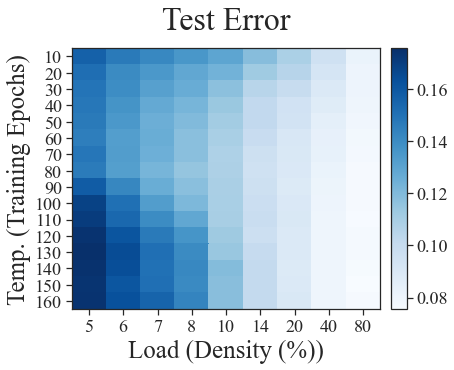

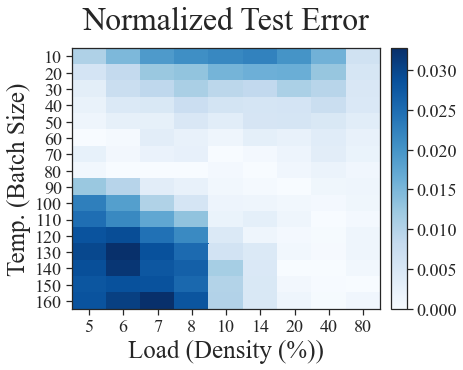

In [16]:
epochs = range(10, 170, 10)
pruning_ratios = [0.95, 0.94, 0.93, 0.92, 0.9, 0.86, 0.8, 0.6, 0.2]                    
full_model_seeds = [1,2,3] # , 4, 5 ,, 2, 3 , 2, 3 2, 3, 4, 5  , 2, 3, 4, 5  , 2, 3, 4, 5
finetune_seeds = [1,2,3] #, 4, 5
finetune_seeds_pairs = [[1, 2], [1, 3], [2, 3]] 
stats_label = 'tr_err'

ratio_epoch_acc_lst = []
for p_ratio in pruning_ratios:
    epoch_acc_lst = []
    for e in epochs:
        final_acc_lst = []
        for full_seed in full_model_seeds:
            for fine_seed in finetune_seeds:
                tgt_solution = f"../checkpoints_public/cv/cifar10/retrain/" + \
                f"SGD/lr_0.1/preresnet20_width1_seed{full_seed}/unif/p_ratio_{p_ratio}/epoch_{e}/retrain_epoch160/retrain_seed{fine_seed}/log_finetune.txt"
                test_acc_lst = []
                with open(tgt_solution.replace('finetune_stats.npy', 'log_finetune.txt')) as f:
                    lines = f.readlines()
                    for l in lines[1:]:
                        test_acc_lst.append((1 - 0.01 * float(l.split('\t')[-2])))      
                final_acc_lst.append(np.mean(test_acc_lst[-5:]))

        final_acc_lst = np.array(final_acc_lst)
        final_acc_mean = np.nanmean(final_acc_lst)
        epoch_acc_lst.append(final_acc_mean)
    ratio_epoch_acc_lst.append(epoch_acc_lst)
ratio_epoch_acc_lst = np.array(ratio_epoch_acc_lst).transpose()
########################################################

x_label_list = [int(100 - int(100 * i)) for i in pruning_ratios]
y_label_list = epochs

generate_plots(x_label_list=x_label_list, 
               y_label_list=y_label_list, 
               data=ratio_epoch_acc_lst, 
               vmin=None, 
               vmax=None, 
               title="Test Error", 
               ylabel="Temp. (Training Epochs)", 
               xlabel="Load (Density (%))", 
               save_path="./earlystop_test_error.png",
               cmap='Blues')

ratio_epoch_acc_lst_norm = min_normalize(ratio_epoch_acc_lst, axis=0, topk=1)

generate_plots(x_label_list=x_label_list, 
               y_label_list=y_label_list, 
               data=ratio_epoch_acc_lst_norm, 
               vmin=None, 
               vmax=None, 
               title="Normalized Test Error", 
               ylabel="Temp. (Batch Size)",
               xlabel="Load (Density (%))", 
               save_path="./normalized_test_error.png",
               cmap='Blues')

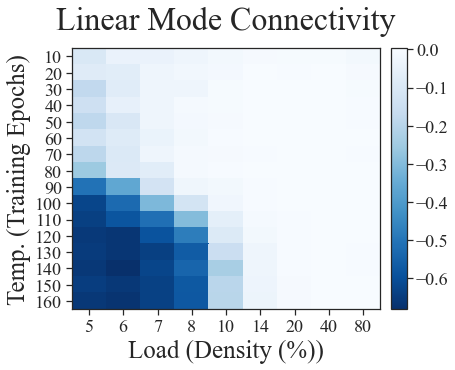

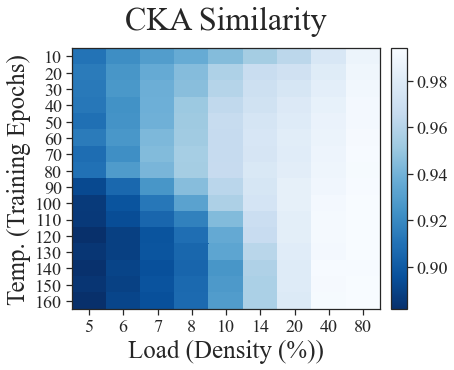

In [17]:
###########################################################################
###########################################################################
ratio_epoch_barrier_height = []
for p_idx, p_ratio in enumerate(pruning_ratios):
    epoch_barrier_height = []
    for e in epochs:
        stats_label = 'tr_err'
        sum_mc = []
        for full_seed in full_model_seeds:
            for pair in [[1, 2], [1, 3], [2, 3]]:
                path = f"../checkpoints_public/cv/cifar10/retrain/" + \
                f"SGD/lr_0.1/preresnet20_width1_seed{full_seed}/unif/p_ratio_{p_ratio}/epoch_{e}/retrain_epoch160/lmc/seed{pair[0]}_seed{pair[1]}/curve_points_11.npz"
                
                curves = np.load(path, allow_pickle=True)
                tr_nll = 0.01 * np.array(curves[stats_label])
                endpoint_mean = 0.5 * (tr_nll[0] + tr_nll[-1])
                index = np.abs(endpoint_mean - tr_nll).argmax()
                barrier_height = endpoint_mean - tr_nll[index]
                sum_mc.append(barrier_height)


        epoch_barrier_height.append(np.nanmean(sum_mc))
    ratio_epoch_barrier_height.append(epoch_barrier_height)
ratio_epoch_barrier_height = np.array(ratio_epoch_barrier_height).transpose()

generate_plots(x_label_list=x_label_list, 
               y_label_list=y_label_list, 
               data=ratio_epoch_barrier_height, 
               vmin=None, 
               vmax=None, 
               title="Linear Mode Connectivity", 
               ylabel="Temp. (Training Epochs)", 
               xlabel="Load (Density (%))", 
               save_path="./earlystop_linear_mc.png",
               cmap='Blues_r')


epoch_ratio_cka_lst = []
for p_ratio in pruning_ratios:
    ratio_cka_list= [] 
    for e in epochs:
        seed_cka_lst = []
        for full_seed in [1, 2, 3]:
            for seed_pair in [[1, 2], [1, 3], [2, 3]]:
                path = f"../checkpoints_public/cv/cifar10/retrain/" + \
                f"SGD/lr_0.1/preresnet20_width1_seed{full_seed}/unif/p_ratio_{p_ratio}/epoch_{e}/retrain_epoch160/" + \
                f"cka/seed{seed_pair[0]}_seed{seed_pair[1]}/similarity_seed{seed_pair[0]}_seed{seed_pair[1]}_removeMaskFalse_meaSeed1_batches100_mixupFalse_alpha16_repeat1_flatFalse_cka_results.npy"
                
                cka_dict = np.load(path, allow_pickle=True)
                seed_cka_lst.append(cka_dict[-1])

        seed_cka_lst = np.array(seed_cka_lst)
        ratio_cka_list.append(np.nanmean(seed_cka_lst))

    epoch_ratio_cka_lst.append(ratio_cka_list)
    
epoch_ratio_cka_lst = np.array(epoch_ratio_cka_lst).transpose()

x_label_list = [int(100 - int(100 * i)) for i in pruning_ratios]
y_label_list = epochs
    
generate_plots(x_label_list=x_label_list, 
               y_label_list=y_label_list, 
               data=epoch_ratio_cka_lst, 
               vmin=None, 
               vmax=None, 
               title="CKA Similarity", 
               ylabel="Temp. (Training Epochs)", 
               xlabel="Load (Density (%))", 
               save_path="./earlystop_cka_similairty.png",
               cmap='Blues_r')